In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Model Comparison

In [2]:
for m in ['1pl','2pl','3pl']:
    
    ## Load ppc.
    ppc = read_csv(os.path.join('stan_results', f'{m}_ppc.csv'))
        
    ## Model comparison.
    louo = ppc.louo.sum()
    loco = ppc.groupby('subject').loco.mean().sum()
    pwaic_u = ppc.pwaic_u.sum()
    pwaic_c = ppc.groupby('subject').pwaic_c.mean().sum()
    
    print('%s:  %0.3f | %0.3f | %0.3f | %0.3f' %(m, louo, loco, pwaic_u, pwaic_c))

1pl:  -13583.776 | -13575.166 | 1073.293 | 161.265
2pl:  -13494.605 | -13561.354 | 917.542 | 248.556
3pl:  -13506.159 | -13360.679 | 899.248 | 262.784


In [36]:
from itertools import combinations

for a, b in list(combinations(['1pl','2pl','3pl'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = df2.groupby('subject').louo.mean() - df1.groupby('subject').louo.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.3f (%0.3f)' %(mu, se))

2pl - 1pl: 5.573 (0.951)
3pl - 1pl: 4.851 (1.368)
3pl - 2pl: -0.722 (0.895)


In [5]:
from itertools import combinations

for a, b in list(combinations(['1pl','2pl','3pl'], 2)):
    
    ## Load data.
    df1 = read_csv(os.path.join('stan_results', f'{a}_ppc.csv'))
    df2 = read_csv(os.path.join('stan_results', f'{b}_ppc.csv'))
    
    arr = df2.groupby('subject').loco.mean() - df1.groupby('subject').loco.mean()
    
    ## Compute stats.
    N = df1.subject.nunique()
    mu = np.sum(arr)
    se = np.std(arr) * np.sqrt(N)
    
    print(f'{b} - {a}: %0.3f (%0.3f)' %(mu, se))

2pl - 1pl: 13.812 (10.439)
3pl - 1pl: 214.487 (21.478)
3pl - 2pl: 200.675 (15.601)


In [26]:
for m in ['1pl','2pl','3pl']:
    
    ## Load ppc.
    ifs = read_csv(os.path.join('stan_results', f'{m}_ifs.csv'))
    print(ifs.query('p >= 0.95').item.values)
   

[ 21  35  61  62  65  96 110 111 124]
[  6  66  90  91 101 118 124]
[  9  21  35  66  79  83  95 123]


In [33]:
hue = np.arange(128)
hue = np.in1d(hue, np.array([9, 21, 35, 66, 79, 83, 95, 123])-1)

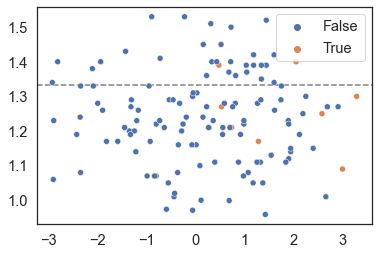

In [34]:
beta  = df.T.filter(regex='beta\[').T['Mean'].values
alpha = df.T.filter(regex='alpha\[').T['Mean'].values
ax = sns.scatterplot(x=beta, y=alpha, hue=hue)
ax.axhline(1 / 0.75, color='0.5', linestyle='--', zorder=-1)

## variance explained

In [37]:
from statsmodels.api import OLS

df = read_csv('stan_results/3pl_summary.tsv', sep='\t', index_col=0)

#### subject ability

In [58]:
rho = df.T.filter(regex='rho').T['Mean'].values
theta = df.T.filter(regex='theta\[').T['Mean'].values
theta -= theta.mean()

## Prepare design matrix.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X1 = read_csv('designs/X1.csv').apply(zscore).fillna(0)
X1 = X1.values

for i in range(1,5):

    mu = X1[:,:i] @ rho[:i]
    mu -= mu.mean()

    fit = OLS(theta, mu).fit()
    print(fit.rsquared.round(3))

0.188
0.199
0.522
0.668


#### item difficulty

In [65]:
beta_mu = df.T.filter(regex='beta_mu').T['Mean'].values
beta = df.T.filter(regex='beta\[').T['Mean'].values
beta -= beta.mean()

## Prepare design matrix.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv('designs/X2.csv').apply(zscore).fillna(1)
X2 = X2.values

for i in range(2,6):

    mu = X2[:,:i] @ beta_mu[:i]
    mu -= mu.mean()

    fit = OLS(beta, mu).fit()
    print(fit.rsquared.round(3))

0.208
0.412
0.565
0.762


In [68]:
.762 - .565

0.19700000000000006

#### item discrimination

In [70]:
alpha_mu = df.T.filter(regex='alpha_mu').T['Mean'].values
alpha = np.log(df.T.filter(regex='alpha\[').T['Mean'].values)
alpha -= alpha.mean()

## Prepare design matrix.
zscore = lambda x: (x - np.nanmean(x)) / np.nanstd(x)
X2 = read_csv('designs/X2.csv').apply(zscore).fillna(1)
X2 = X2.values

for i in range(2,6):

    mu = X2[:,:i] @ alpha_mu[:i]
    mu -= mu.mean()

    fit = OLS(alpha, mu).fit()
    print(fit.rsquared.round(3))

0.196
0.794
0.81
0.86


In [72]:
15 * 12 / 60

3.0

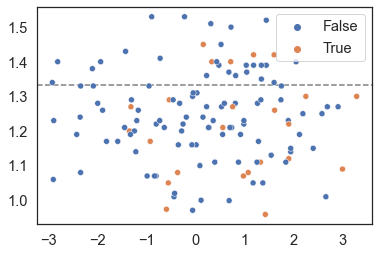

In [28]:
items = [ 6, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 39, 40, 42, 44, 45, 46, 47,
       49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
dif = [ 6, 18, 24, 26, 34, 47, 50, 52, 54, 61, 66, 75]

hue = np.repeat(np.in1d(items, dif), 2)

beta  = df.T.filter(regex='beta\[').T['Mean'].values
alpha = df.T.filter(regex='alpha\[').T['Mean'].values
ax = sns.scatterplot(x=beta, y=alpha, hue=hue)
ax.axhline(1 / 0.75, color='0.5', linestyle='--', zorder=-1)

In [31]:
hue

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False]

In [ ]:
## Load data.
data = read_csv(os.path.join('data', 'data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data', 'reject.csv'))
data = data.loc[data.subject.isin(reject.query('reject==0').subject)]

## Re-index items.
data['item_id'] = data.apply(lambda x: '%0.2d' %x['item'] + '_' + x['distractor'], 1)

## Score missing data.
data['accuracy'] = data['accuracy'].fillna(0)

In [ ]:
from statsmodels.api import OLS

y = data.groupby('item_id').rt.mean().values
X = np.column_stack([np.ones_like(beta), zscore(beta), zscore(alpha)])


fit = OLS(y, X).fit()
fit.summary()

In [ ]:
from statsmodels.api import OLS

y = np.log(alpha)
x = zscore(data.groupby('item_id').rt.mean().values)
X = np.column_stack([np.ones_like(beta), x, x**2])


fit = OLS(y, X).fit()
fit.summary()

## Section 2: Item Description

/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/szoro/Documents/software/anaconda3.7/lib/python3.7/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


<AxesSubplot:xlabel='accuracy'>

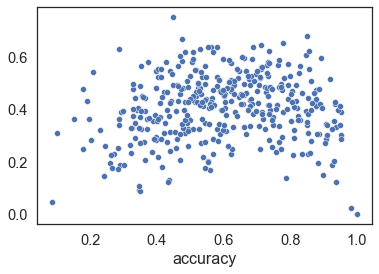

In [3]:
sum_scores = data.groupby('subject').accuracy.sum()
f = lambda x: np.corrcoef(sum_scores[x.subject], x.accuracy)[0,1]
a = data.groupby('item_id').apply(f).fillna(0)
b = data.groupby('item_id').accuracy.mean()
sns.scatterplot(x=b, y=a)